In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 36.9 MB/s 
     |████████████████████████████████| 596 kB 31.6 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 290 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 36.9 MB/s 
     |████████████████████████████████| 132 kB 49.4 MB/s 
     |████████████████████████████████| 243 kB 47.1 MB/s 
     |████████████████████████████████| 160 kB 47.2 MB/s 
     |████████████████████████████████| 271 kB 48.0 MB/s 
     |████████████████████████████████| 192 kB 48.2 MB/s 
     |████████████████████████████████| 123 kB 5.4 MB/s 
     |████████████████████████████████| 131 kB 26.0 MB/s 
     |████████████████████████████████| 79 k

In [3]:
import os
import time
import datetime
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random
import copy

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers.models.gpt2.modeling_gpt2 import GPT2DoubleHeadsModelOutput

from datasets import load_dataset

from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer

from pytorch_pretrained_bert.modeling_gpt2 import GPT2PreTrainedModel, GPT2MultipleChoiceHead, GPT2Model, GPT2LMHead, Attention, Block, \
    LayerNorm, MLP

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="/content/drive/My Drive/Colab Notebooks" )

Downloading:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-7330ead6fca24743


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-7330ead6fca24743/1.0.0/61d5d736f7a6a127fff0ac0182263d45c2e2192a6af6c4459f2d4a3d22083ef4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
cd_df = covid_dialog['train'].to_pandas()
# cd_df.head()
print(cd_df["dialogue_turns"][0]["utterance"])

['I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help.'
 'Hello, I understand your concern. I just have a few more questions.Does your cough has phlegm? Any other symptoms like difficulty breathing? Any other medical condition such as asthma, hypertension? Are you a smoker? Alcoholic beverage drinker?'
 'Thank you doctor,I have phlegm but not a lot. A tiny amount comes out most of the time. I have no difficulty in breathing. No medical conditions and not a smoker nor a drinker.'
 'Hi, I would recommend you take n-acetylcysteine 200 mg powder dissolved in water three times a day. You may also nebulize using PNSS (saline nebulizer) three

In [6]:
# Here we have only text 
patient_text = []
doctor_text = []
text = []
for dial in cd_df["dialogue_turns"]:
  patient_temp = []
  doctor_temp = []
  u = dial["utterance"]
  for i in range(len(u)):
    if i % 2 == 0:
      patient_temp.append(u[i])
      # patient = " ".join(patient_text)
    else:
      doctor_temp.append(u[i])
      # doctor = " ".join(doctor_text)
  patient = " ".join(patient_temp)
  doctor = " ".join(doctor_temp)
  patient_text.append([''.join(patient)])
  doctor_text.append([''.join(doctor)])

text = [patient_text, doctor_text]
text = np.transpose(np.array(text).reshape((2, -1)))
print(text.shape)
qa_df = pd.DataFrame(text, columns=["patient", "doctor"])
qa_df["text"] = qa_df["patient"] + qa_df["doctor"]
qa_df.head()

(572, 2)


,patient,doctor,text
0,I have cough with no travel history. Is this a...,"Hello, I understand your concern. I just have ...",I have cough with no travel history. Is this a...
1,I have a little fever with no history of forei...,"Hello, I can understand your concern.In my opi...",I have a little fever with no history of forei...
2,Can Coronavirus cause itchiness in throat and ...,Hello. Anxiety can manifest itself in physical...,Can Coronavirus cause itchiness in throat and ...
3,"I have chills, breathing problems and cough wi...","Hello,please answer the following:Any travel h...","I have chills, breathing problems and cough wi..."
4,Does COVID-19 spreads through water? What prec...,Hello and welcome to Ask A Doctor service.I ha...,Does COVID-19 spreads through water? What prec...


In [7]:
text = qa_df.text.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


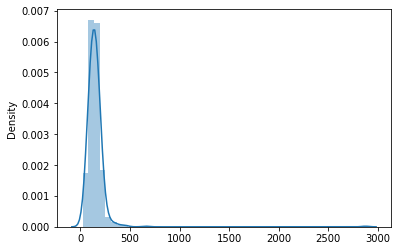

In [8]:
doc_lengths = []

for bio in text:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [9]:
torch.cuda.empty_cache()

In [10]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [11]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt + tokenizer.eos_token, truncation=True, max_length=max_length, padding="max_length")
      print(encodings_dict)
      
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [14]:
dataset = GPT2Dataset(text, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

{'input_ids': [40, 423, 22094, 351, 645, 3067, 2106, 13, 1148, 428, 257, 25993, 286, 39751, 312, 12, 1129, 30, 15496, 6253, 11, 314, 651, 257, 22094, 329, 262, 938, 1178, 1528, 11, 543, 318, 4334, 1141, 1755, 1661, 13, 1400, 5298, 287, 5951, 475, 4203, 10032, 351, 645, 3067, 2106, 13, 1400, 2800, 351, 597, 39751, 312, 12, 1129, 6506, 13, 632, 468, 587, 1440, 284, 1936, 1528, 290, 468, 10785, 257, 1256, 286, 3932, 324, 563, 75, 290, 1718, 2547, 23253, 321, 349, 1165, 13, 28274, 423, 4423, 262, 13349, 523, 466, 407, 760, 644, 284, 466, 30, 4222, 1037, 13, 6952, 345, 6253, 11, 40, 423, 872, 1455, 76, 475, 407, 257, 1256, 13, 317, 7009, 2033, 2058, 503, 749, 286, 262, 640, 13, 314, 423, 645, 8722, 287, 12704, 13, 1400, 3315, 3403, 290, 407, 257, 41644, 4249, 257, 4144, 263, 13, 15496, 11, 314, 1833, 534, 2328, 13, 314, 655, 423, 257, 1178, 517, 2683, 13, 13921, 534, 22094, 468, 872, 1455, 76, 30, 4377, 584, 7460, 588, 8722, 12704, 30, 4377, 584, 3315, 4006, 884, 355, 28438, 11, 37454, 30, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [16]:
useCuda = True

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [18]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()
# else:
#   device = torch.device("cpu")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [19]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [21]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [22]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [23]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 10,
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.9836387038230896.   Elapsed: 0:01:40.
0: In brief: I suspect it will be much more difficult to have a chat with someone if you do not have access to a doctor. In brief: I suspect it will be much more difficult to chat with someone if you do not have access to a doctor.In brief: I suspect it will be much more difficult to have a chat with someone if you do not have access to a doctor.In brief: I suspect it will be more difficult to chat with someone if you do not have access to a doctor.In brief: I suspect it will be more difficult to chat with someone if you do not have access to a doctor.In brief: I suspect it will be much more difficult to chat with someone when the doctor.In brief:  I suspect it will be hard to chat with patients with someone with someone who might be very quickly.In brief:      and see someone for you and get chat with this and can do not have access their symptoms from you or


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.29107561707496643.   Elapsed: 0:03:24.
0: . cnn.com?P.armello.com?The main issue is now that I want to make sure that I will be happy with the product, rather than feeling sick, and feeling tired, and feeling bad, and feeling tired, and feeling tired, and feeling bad, and feeling bad, and still in the shower to the same extent or other things that come up. If you are in high risk area, go to low risk area. Also, you may have pneumonia or another flu that is just more in your head as a result.

  Average training loss: 1.09
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:09

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.6210970282554626.   Elapsed: 0:01:39.
0: .........


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 1.2897816896438599.   Elapsed: 0:03:19.
0: !?!?!?!?!

  Average training loss: 0.64
  Training epoch took: 0:04:15

Running Validation...
  Validation Loss: 0.61
  Validation took: 0:00:09

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.5739975571632385.   Elapsed: 0:01:40.
0: ’s  heavy for covid19.  I am thinking they need to lower the temperature for the treatment.    Please ask a doctor’s doctor’s opinion on the need to lower the temperature of the treatment.   Please consider a virtual visit to your PCP (care can be done at home, with a pointed mask, mask, or a mask on your mask.    Call the hotline for test.I  Would you like to video or text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.4484308660030365.   Elapsed: 0:03:21.
0: ?,..,..?,.

  Average training loss: 0.51
  Training epoch took: 0:04:17

Running Validation...
  Validation Loss: 0.60
  Validation took: 0:00:09

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.7163702845573425.   Elapsed: 0:01:40.
0: .   What the heck is a temperature?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.40623101592063904.   Elapsed: 0:03:20.
0:  was once told I had a viral upper airway obstruction but that was a myth. The GP advised against it. Three days later, I fell ill and the doctor put me on amoxy relaxant. What next? Should I get tested again? My mom has been told I have a viral upper airway obstruction so I have had it a week on various medications. Should I get tested again? My mom has been told I have a viral upper airway obstruction so I have had it a week on various medications. Should I get tested again?In brief:     Coronavirus    It might be corona virus. Your mom may have a viral upper airway obstruction, but need to consult a doctor first.    Would you like to video or text chat with me?

  Average training loss: 0.41
  Training epoch took: 0:04:20

Running Validation...
  Validation Loss: 0.61
  Validation took: 0:00:09

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    257. Loss: 0.22188697755336761.   Elapsed: 0:01:40.
0: ,.,...??,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    257. Loss: 0.581882894039154.   Elapsed: 0:03:20.
0:  are the chances of severe bronchitis increases with treatment for pneumonia, despite being treated with levaquin, as in pneumonia treatment, and other advanced cases?Are the chances of severe bronchitis increases with treatment for pneumonia, despite being treated with levaquin, as in pneumonia treatment, and other advanced cases?Continue the search. We know there are limits. BE grateful for your help..

  Average training loss: 0.33
  Training epoch took: 0:04:19

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:09

Training complete!
Total training took 0:22:19 (h:mm:ss)


In [24]:
import pandas as pd
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.09,0.66,0:04:22,0:00:09
2,0.64,0.61,0:04:15,0:00:09
3,0.51,0.60,0:04:17,0:00:09
4,0.41,0.61,0:04:20,0:00:09
5,0.33,0.65,0:04:19,0:00:09


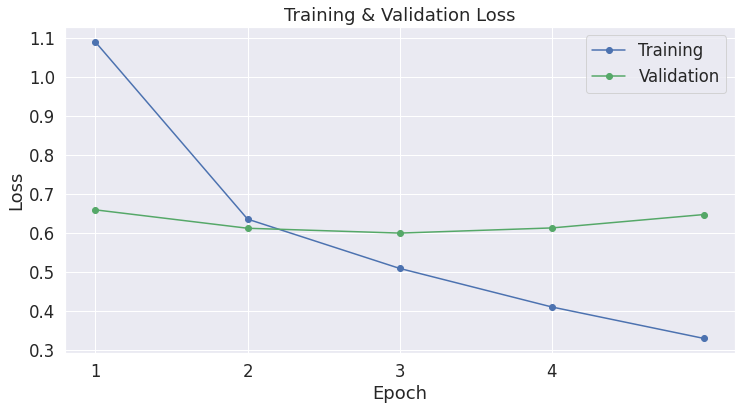

In [25]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [26]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [32]:
step = 0
# model.playmode = True
model = model.to('cpu')
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    # bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1
    bot_input_ids1 = new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, min_length=10, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

>> User:I just got back from Europe. Should I get tested from COVID-19?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT:  Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Should I get tested from Europe? Europe. Europe.
>> User:I have a dry cough. Could I have COVID-19?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: I have a dry cough. Could I have COVID-19?In brief:   Fever, dry cough, headache, body aches.   If you have access to testing you can do that.   Would you like to video or text chat with me?
>> User:I am done talking
DialoGPT: Ok bye bye


In [28]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

cpu
cpu


In [29]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')